In [45]:
# Import system libs
import os
import itertools

In [47]:
# Import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from tensorflow.keras.preprocessing import image

In [49]:
# Import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [51]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
 

In [53]:
# Load and preprocess the data
def loading_the_data(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)
    return df

In [55]:
def change_label_names(df, column_name):
    index = {'lung_aca': 'Lung_adenocarcinoma', 'lung_n': 'Lung_benign_tissue', 'lung_scc': 'Lung squamous_cell_carcinoma'}
    df[column_name] = df[column_name].replace(index)

data_dir = r'C:\Users\andre\Downloads\archive\lung_colon_image_set\lung_image_sets'
df = loading_the_data(data_dir)
change_label_names(df, 'labels')

df_data_balance = df.labels.value_counts()
def custom_autopct(pct):
    total = sum(df_data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

C:\Users\andre\AppData\Local\Temp\ipykernel_23232\3021865720.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


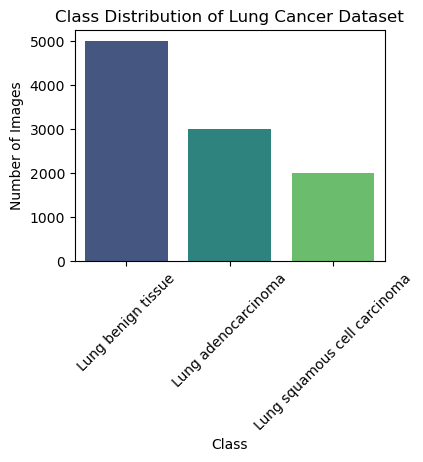

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example data
data = {'label': ['Lung benign tissue'] * 5000 + ['Lung adenocarcinoma'] * 3000 + ['Lung squamous cell carcinoma'] * 2000}
df = pd.DataFrame(data)

# Count the number of occurrences of each class
class_distribution = df['label'].value_counts()

# Plot the class distribution
plt.figure(figsize=(4, 3))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Class Distribution of Lung Cancer Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


In [59]:
# Split the data
train_df, ts_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(ts_df, train_size=0.5, shuffle=True, random_state=42)

In [61]:
# Data generators
batch_size = 32
img_size = (224, 224)
tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

g_dict = train_gen.class_indices
classes = list(g_dict.keys())

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


In [62]:
# Define CNN model
def conv_block(filters, act='relu'):
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())
    return block

def dense_block(units, dropout_rate, act='relu'):
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    return block

img_shape = (img_size[0], img_size[1], 3)
class_counts = len(list(train_gen.class_indices.keys()))
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape=img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())
cnn_model.add(conv_block(32))
cnn_model.add(conv_block(64))
cnn_model.add(conv_block(128))
cnn_model.add(conv_block(256))
cnn_model.add(Flatten())
cnn_model.add(dense_block(128, 0.5))
cnn_model.add(dense_block(64, 0.3))
cnn_model.add(dense_block(32, 0.2))
cnn_model.add(Dense(class_counts, activation="softmax"))
cnn_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adamax

# Define and compile CNN model
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape=img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())
cnn_model.add(conv_block(32))
cnn_model.add(conv_block(64))
cnn_model.add(conv_block(128))
cnn_model.add(conv_block(256))
cnn_model.add(Flatten())
cnn_model.add(dense_block(128, 0.5))
cnn_model.add(dense_block(64, 0.3))
cnn_model.add(dense_block(32, 0.2))
cnn_model.add(Dense(class_counts, activation="softmax"))
cnn_model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [72]:
# Train the CNN model
cnn_history = cnn_model.fit(
    train_gen, 
    epochs=10, 
    verbose=1, 
    validation_data=valid_gen, 
    shuffle=False
)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 807s 2s/step - accuracy: 0.9158 - loss: 0.2356 - val_accuracy: 0.8960 - val_loss: 0.3302
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 728s 2s/step - accuracy: 0.9334 - loss: 0.1811 - val_accuracy: 0.9447 - val_loss: 0.1285
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 672s 2s/step - accuracy: 0.9485 - loss: 0.1393 - val_accuracy: 0.9453 - val_loss: 0.1500
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 668s 2s/step - accuracy: 0.9585 - loss: 0.1237 - val_accuracy: 0.9487 - val_loss: 0.1683
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 665s 2s/step - accuracy: 0.9598 - loss: 0.1132 - val_accuracy: 0.8940 - val_loss: 0.3568
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 665s 2s/step - accuracy: 0.9663 - loss: 0.0968 - val_accuracy: 0.9760 - val_loss: 0.0652
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 681s 2s/step - accuracy: 0.9677 - loss: 0.0925 - val_accuracy: 0.9220 - val_loss: 0.2073
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 702s 2s/step - accuracy: 0.9760 - loss: 0.0712 - val_accu

In [121]:
# Save CNN model
cnn_model.save('cnn_model.keras')

47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 625ms/step


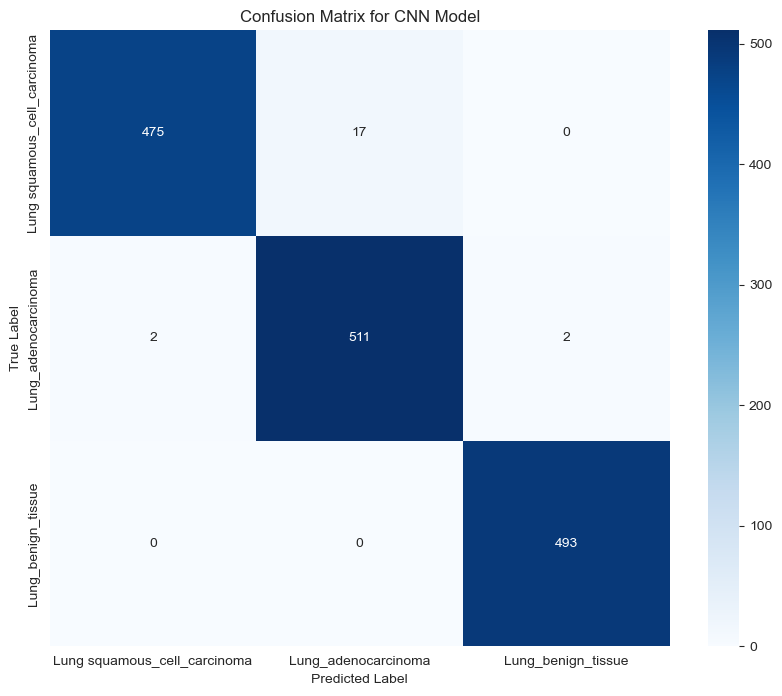

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to get predictions
def get_predictions(model, generator):
    # Predict the probabilities for each class
    predictions = model.predict(generator)
    # Convert probabilities to class labels
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels

# Function to plot the confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix for CNN Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Get the true labels from the generator
true_labels = test_gen.classes

# Get the predicted labels from the CNN model
cnn_y_pred = get_predictions(cnn_model, test_gen)

# Plot the confusion matrix
plot_confusion_matrix(true_labels, cnn_y_pred, list(test_gen.class_indices.keys()))


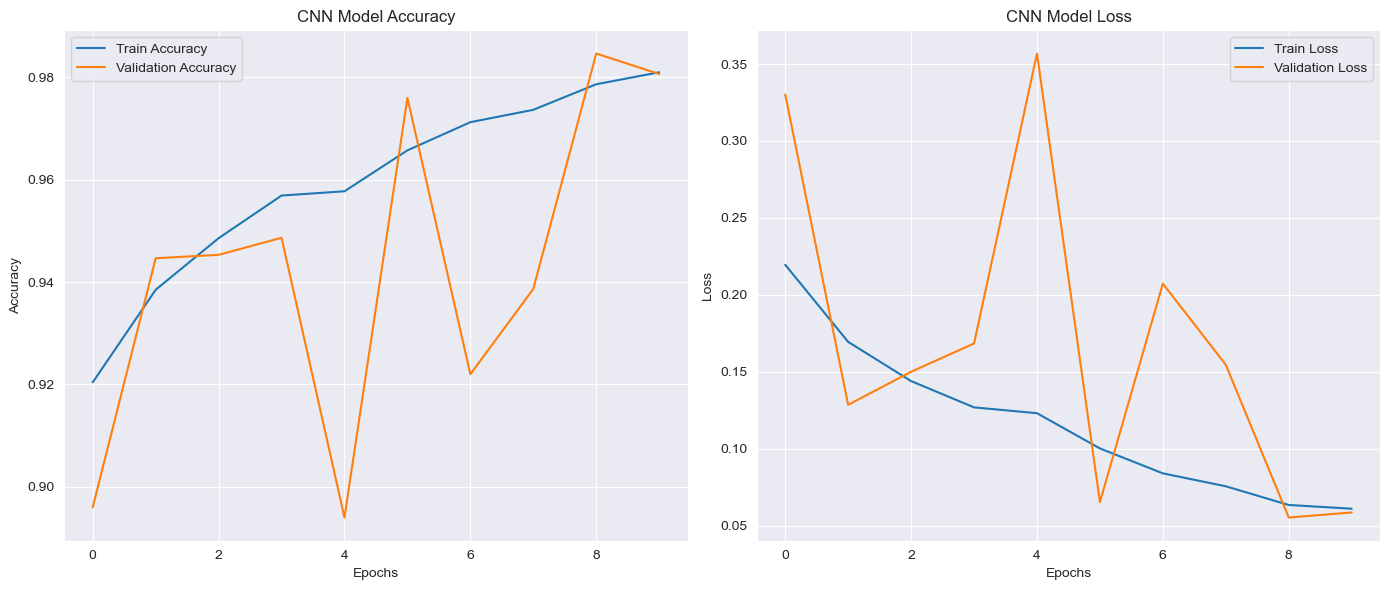

In [119]:
import matplotlib.pyplot as plt

def plot_cnn_performance(cnn_history):
    # Plot accuracy
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
    plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('CNN Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(cnn_history.history['loss'], label='Train Loss')
    plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
    plt.title('CNN Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

# Assuming you have the cnn_history object from training
plot_cnn_performance(cnn_history)


In [127]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax

# Define and compile EfficientNetB3 model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=img_shape, pooling=None)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation="softmax")(x)
EfficientNetB3_model = Model(inputs=base_model.input, outputs=predictions)
EfficientNetB3_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [128]:
# Train the EfficientNetB3 model
efficientnetb3_history = EfficientNetB3_model.fit(
    train_gen, 
    epochs=3, 
    verbose=1, 
    validation_data=valid_gen, 
    shuffle=False
)

Epoch 1/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 3447s 9s/step - accuracy: 0.6740 - loss: 0.8525 - val_accuracy: 0.3507 - val_loss: 1.4632
Epoch 2/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 3631s 10s/step - accuracy: 0.9096 - loss: 0.2623 - val_accuracy: 0.6793 - val_loss: 0.8876
Epoch 3/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 3608s 10s/step - accuracy: 0.9487 - loss: 0.1568 - val_accuracy: 0.9853 - val_loss: 0.0582


In [131]:
# Save EfficientNetB3 model
EfficientNetB3_model.save('efficientnetb3_model.keras')

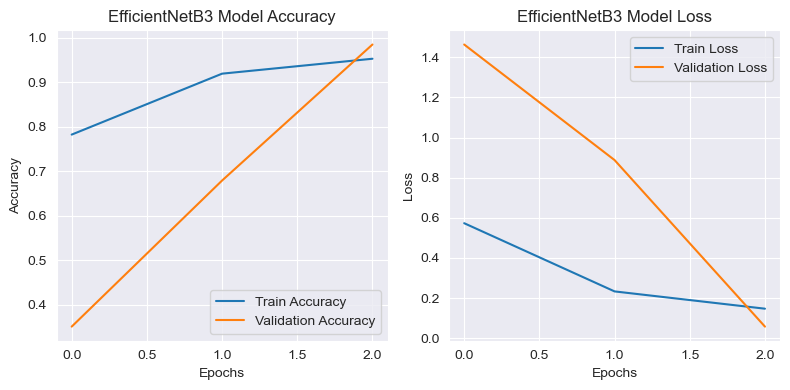

In [145]:
def plot_efficientnetb3_performance(efficientnetb3_history):
    # Plot accuracy
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.plot(efficientnetb3_history.history['accuracy'], label='Train Accuracy')
    plt.plot(efficientnetb3_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('EfficientNetB3 Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(efficientnetb3_history.history['loss'], label='Train Loss')
    plt.plot(efficientnetb3_history.history['val_loss'], label='Validation Loss')
    plt.title('EfficientNetB3 Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

# Assuming you have the efficientnetb3_history object from training
plot_efficientnetb3_performance(efficientnetb3_history)


47/47 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step


<Figure size 1000x800 with 0 Axes>

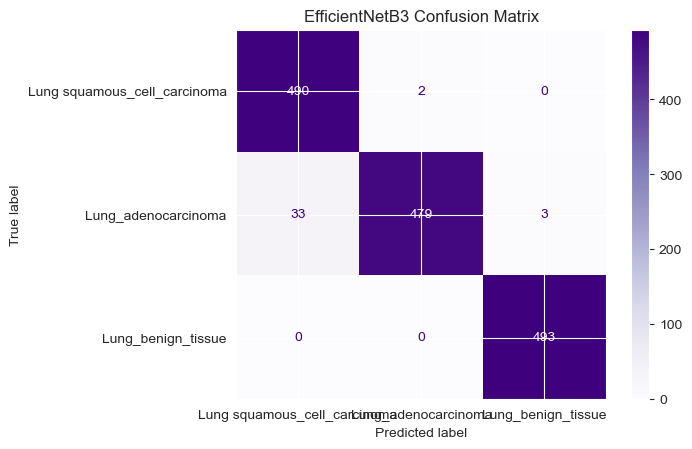

In [154]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Function to get predictions
def get_predictions(model, generator):
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    return y_pred_classes

# Function to plot confusion matrix
def plot_confusion_matrix(generator, y_pred, model_name='Model'):
    y_true = generator.classes
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=generator.class_indices.keys())

    plt.figure(figsize=(10, 8))
    cm_display.plot(cmap=plt.cm.Purples, values_format='d')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# Assuming you have trained the EfficientNetB3 model and have the test generator
efficientnetb3_y_pred = get_predictions(EfficientNetB3_model, test_gen)
plot_confusion_matrix(test_gen, efficientnetb3_y_pred, model_name='EfficientNetB3')


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of the data will be used for validation
)

# Define the data directory
data_dir = r'C:\Users\andre\Downloads\archive\lung_colon_image_set\lung_image_sets'

# Create data generators
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Adjust based on model input size
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

valid_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Adjust based on model input size
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Load the pre-trained CNN model
cnn_model = load_model('cnn_model.keras')

# Unfreeze some layers in the CNN model
for layer in cnn_model.layers:
    layer.trainable = True

# Recompile the model with a lower learning rate
cnn_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the CNN model on the new dataset
cnn_history = cnn_model.fit(
    train_gen, 
    epochs=5, 
    validation_data=valid_gen
)

# Save the fine-tuned model
cnn_model.save('cnn_model_finetuned.keras')


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained EfficientNetB3 model
efficientnetb3_model = load_model('efficientnetb3_model.keras')

# Unfreeze some layers in the EfficientNetB3 model
for layer in efficientnetb3_model.layers:
    layer.trainable = True

# Recompile the model with a lower learning rate
efficientnetb3_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the EfficientNetB3 model on the new dataset
efficientnetb3_history = efficientnetb3_model.fit(
    train_gen, 
    epochs=3, 
    validation_data=valid_gen
)

# Save the fine-tuned model
efficientnetb3_model.save('efficientnetb3_model_finetuned.keras')
